# Praca domowa nr 4 - przetwarzanie obrazów
### Sebastian Deręgowski, Maciej Gryszkiewicz, Piotr Okonek

W tej części pracy domowej stworzyliśmy funkcje, pozwalające na preprocessing danych obrazowych. Ich główne funkcjonalności to:
- Ujednolicanie rozmiaru zdjęć
- Normalizacja wartości pikseli- z przedziału [0,255] na [0,1]
- Uszuwanie szumu

Dodatkowo zostały zaimplementowane funkcje, segmentujące obiekty na zdjęciu oraz w tle.

Zdjęcia w różnych bazach są różnie poukładane w katalogach, więc nie da się napisać jednej funkcji zapisującej ścieżki do obrazów w tablicy. 

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image
from numpy import asarray

Przykład zapisania ścieżek do zdjęć.

In [2]:
from os import listdir
from os.path import isfile, join
path = 'D:/piotr/4 semestr/Warsztaty/chest_xray'
all_files = []
train_pneumonia = [f for f in listdir(path+'/'+'train/PNEUMONIA') if isfile(join(path+'/'+'train/PNEUMONIA', f))]
for file in train_pneumonia:
    all_files.append(path+'/'+'train/PNEUMONIA/'+file)
train_normal = [f for f in listdir(path+'/'+'train/NORMAL') if isfile(join(path+'/'+'train/NORMAL', f))]
for file in train_normal:
    all_files.append(path+'/'+'train/NORMAL/'+file)
test_pneumonia = [f for f in listdir(path+'/'+'test/PNEUMONIA') if isfile(join(path+'/'+'test/PNEUMONIA', f))]
for file in test_pneumonia:
    all_files.append(path+'/'+'test/PNEUMONIA/'+file)
test_normal = [f for f in listdir(path+'/'+'test/NORMAL') if isfile(join(path+'/'+'test/NORMAL', f))]
for file in test_normal:
    all_files.append(path+'/'+'test/NORMAL/'+file)

Nasza główna funkcja `processing` przyjmuje 2 argumenty. Pierwszy tablica ze ścieżkami do zdjęć a drugi, na potrzeby prezentacji działania, ile zdjęć chcemy przerobić.

In [27]:
# Wyświetl 1 zdjęcie
def display_one(a, title1 = "Original"):
    plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.show()
# Wyświetl 2 zdjęcia
def display(a, b, title1 = "Original", title2 = "Edited"):
    plt.subplot(121), plt.imshow(a), plt.title(title1)
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(b), plt.title(title2)
    plt.xticks([]), plt.yticks([])
    plt.show()

# Preprocessing
def processing(data,photos_number):
    
    # Reading 3 images to work
    img = [cv2.imread(i, cv2.IMREAD_UNCHANGED) for i in data[:photos_number]]
    try:
        print('Original size',img[0].shape)
    except AttributeError:
        print("shape not found")
   
    # --------------------------------
    # Ujednolicenie rozmiaru zdjec
    height = 220
    width = 220
    dim = (width, height)
    res_img = []
    for i in range(len(img)):
        res = cv2.resize(img[i], dim, interpolation=cv2.INTER_LINEAR)
        res_img.append(res)

    # Sprawdzamy, czy działa
    try:
        print('RESIZED', res_img[1].shape)
    except AttributeError:
        print("shape not found")
    # Normalizacja wartości pikseli do przedziału [0,1]
    print("Normalizacja wartości pikseli: \n")
    for i in range(len(res_img)):
        pixels = asarray(res_img[i])
        print("Before: ")
        print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
        pixels = pixels.astype('float32')
        pixels /= 255.0
        print("After: ")
        print('Min: %.3f, Max: %.3f\n' % (pixels.min(), pixels.max()))
    
    # Wyświetl zdjęcie po ujednoliceniu
    original = res_img[1]
    display_one(original)
    # ----------------------------------
    # Usuwanie szumu
    no_noise = []
    for i in range(len(res_img)):
        blur = cv2.GaussianBlur(res_img[i], (5, 5), 0)
        no_noise.append(blur)


    image = no_noise[1]
    display(original, image, 'Original', 'Blured')
    #---------------------------------
    # Segmentacja
    ret, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Wyświetlenie po segmentacji
    display(original, thresh, 'Original', 'Segmented')
    # Dalsze usuwanie szumu
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

  
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

   
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    
    display(original, sure_bg, 'Original', 'Segmented Background')


Original size (760, 1152)
RESIZED (220, 220)
Normalizacja wartości pikseli: 

Before: 
Min: 0.000, Max: 254.000
After: 
Min: 0.000, Max: 0.996

Before: 
Min: 0.000, Max: 254.000
After: 
Min: 0.000, Max: 0.996

Before: 
Min: 0.000, Max: 255.000
After: 
Min: 0.000, Max: 1.000

Before: 
Min: 0.000, Max: 255.000
After: 
Min: 0.000, Max: 1.000

Before: 
Min: 0.000, Max: 250.000
After: 
Min: 0.000, Max: 0.980



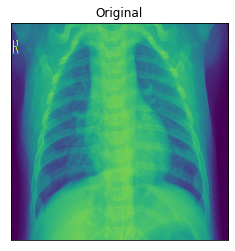

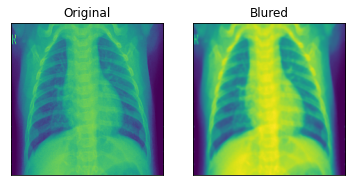

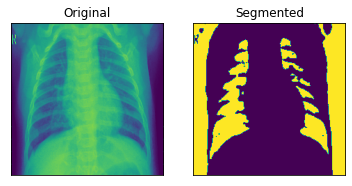

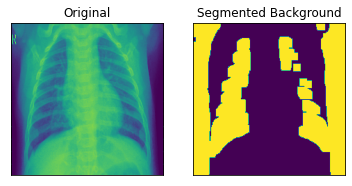

In [28]:
processing(all_files,5)

Widzimy, jak zmieniał się obraz od oryginalnego do ostatecznego po preprocesingu. 